# Demo for using the code base

## We load the different packages

In [8]:
import pandas as pd, datetime as dt, matplotlib.pyplot as plt, numpy as np, os, sys
import py_vollib_vectorized

from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_vollib.black_scholes.greeks.analytical import delta

%matplotlib inline 

In [10]:
# importing functions from the code base
base_path = os.path.abspath(os.path.join('..'))
print(base_path)
if base_path not in sys.path:
    sys.path.append(base_path)

/Users/nicolas/Projects/crypto_option_dashboard


In [11]:
import src.api as api

## Getting the instruments

The following function allow us to get the instruments available in Deribit

In [12]:
import nest_asyncio
nest_asyncio.apply()
instruments = api.get_instruments("BTC", kind="option", expired=False)
instruments.head()

,tick_size,taker_commission,strike,settlement_period,rfq,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,contract_size,block_trade_commission,base_currency,creation_time,expiration_time
0,0.0005,0.0003,55000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-24JUN22-55000-C,1656057600000,1629483660000,1.0,0.00015,BTC,2021-08-20 19:21:00,2022-06-24 09:00:00
1,0.0005,0.0003,41000.0,day,False,BTC,put,0.1,0.0003,option,True,BTC-30JAN22-41000-P,1643529600000,1643356920000,1.0,0.00015,BTC,2022-01-28 08:02:00,2022-01-30 08:00:00
2,0.0005,0.0003,30000.0,month,False,BTC,call,0.1,0.0003,option,True,BTC-24JUN22-30000-C,1656057600000,1627994072000,1.0,0.00015,BTC,2021-08-03 13:34:32,2022-06-24 09:00:00
3,0.0005,0.0003,45000.0,month,False,BTC,put,0.1,0.0003,option,True,BTC-25MAR22-45000-P,1648195200000,1628197380000,1.0,0.00015,BTC,2021-08-05 22:03:00,2022-03-25 08:00:00
4,0.0005,0.0003,36000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-4FEB22-36000-C,1643961600000,1642801680000,1.0,0.00015,BTC,2022-01-21 21:48:00,2022-02-04 08:00:00


In [13]:
# get all settlements time
print(instruments.expiration_time.unique())

['2022-06-24T09:00:00.000000000' '2022-01-30T08:00:00.000000000'
 '2022-03-25T08:00:00.000000000' '2022-02-04T08:00:00.000000000'
 '2022-09-30T09:00:00.000000000' '2022-04-29T09:00:00.000000000'
 '2022-12-30T08:00:00.000000000' '2022-02-11T08:00:00.000000000'
 '2022-02-18T08:00:00.000000000' '2022-02-25T08:00:00.000000000'
 '2022-01-31T08:00:00.000000000']


In [14]:
instruments.expiration_time.min()

Timestamp('2022-01-30 08:00:00')

<AxesSubplot:>

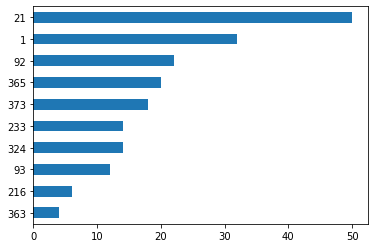

In [15]:
# get all options type for the closest settlement time
date_of_interest = instruments.expiration_time.min()
instruments["life_of_option"]=instruments.expiration_time-instruments.creation_time
instruments["life_of_option"].dt.days.value_counts().head(10).sort_values().plot(kind = 'barh')
#instruments.sort_values(by=["life_of_option","expiration_time"],ascending=[0,1]).head()

In [16]:
instruments_21t=instruments.loc[instruments.life_of_option.dt.days==21]
instruments_21t.head()

,tick_size,taker_commission,strike,settlement_period,rfq,quote_currency,option_type,min_trade_amount,maker_commission,kind,is_active,instrument_name,expiration_timestamp,creation_timestamp,contract_size,block_trade_commission,base_currency,creation_time,expiration_time,life_of_option
14,0.0005,0.0003,60000.0,week,False,BTC,put,0.1,0.0003,option,True,BTC-4FEB22-60000-P,1643961600000,1642084380000,1.0,0.00015,BTC,2022-01-13 14:33:00,2022-02-04 08:00:00,21 days 17:27:00
17,0.0005,0.0003,36000.0,week,False,BTC,put,0.1,0.0003,option,True,BTC-18FEB22-36000-P,1645171200000,1643270402000,1.0,0.00015,BTC,2022-01-27 08:00:02,2022-02-18 08:00:00,21 days 23:59:58
24,0.0005,0.0003,60000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-4FEB22-60000-C,1643961600000,1642084380000,1.0,0.00015,BTC,2022-01-13 14:33:00,2022-02-04 08:00:00,21 days 17:27:00
28,0.0005,0.0003,50000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-18FEB22-50000-C,1645171200000,1643293140000,1.0,0.00015,BTC,2022-01-27 14:19:00,2022-02-18 08:00:00,21 days 17:41:00
30,0.0005,0.0003,36000.0,week,False,BTC,call,0.1,0.0003,option,True,BTC-18FEB22-36000-C,1645171200000,1643270402000,1.0,0.00015,BTC,2022-01-27 08:00:02,2022-02-18 08:00:00,21 days 23:59:58


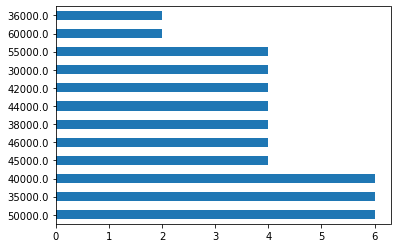

In [17]:
instruments_21t.strike.value_counts().plot(kind='barh');

In [18]:
# We will look at the call that has the median strike for the date_of_interest
option_type_of_interest="call"
date_of_interest=instruments_21t.expiration_time.min()
strike_of_interest=instruments_21t.loc[(instruments.expiration_time == date_of_interest) & (instruments.option_type == option_type_of_interest)].strike.max()
print(strike_of_interest)

60000.0


In [19]:
instrument_data = instruments_21t.loc[
    (instruments.expiration_time == date_of_interest)
    & (instruments.option_type == option_type_of_interest)
    & (instruments.strike == strike_of_interest)
]
instrument_dict = instrument_data.to_dict("records")[0]
instrument_dict

{'tick_size': 0.0005,
 'taker_commission': 0.0003,
 'strike': 60000.0,
 'settlement_period': 'week',
 'rfq': False,
 'quote_currency': 'BTC',
 'option_type': 'call',
 'min_trade_amount': 0.1,
 'maker_commission': 0.0003,
 'kind': 'option',
 'is_active': True,
 'instrument_name': 'BTC-4FEB22-60000-C',
 'expiration_timestamp': 1643961600000,
 'creation_timestamp': 1642084380000,
 'contract_size': 1.0,
 'block_trade_commission': 0.00015,
 'base_currency': 'BTC',
 'creation_time': Timestamp('2022-01-13 14:33:00'),
 'expiration_time': Timestamp('2022-02-04 08:00:00'),
 'life_of_option': Timedelta('21 days 17:27:00')}

We now have an option that we want to backtest, i the next step we will pull the data for this option

## Getting the historical data

In [20]:
time_period = "1D"

option_data = api.get_historical_data(
    instrument_dict["creation_timestamp"],
    instrument_dict["expiration_timestamp"],
    instrument_dict["instrument_name"],
    time_period,
)
print(option_data.count())
option_data.head()

volume       17
ticks        17
status       17
open         17
low          17
high         17
cost         17
close        17
timestamp    17
dtype: int64


,volume,ticks,status,open,low,high,cost,close,timestamp
0,25.2,1642032000000,ok,43208.9000,0.0025,43208.9000,0.00550,0.0025,2022-01-13
1,11.0,1642118400000,ok,0.0020,0.0020,0.0020,0.02200,0.0020,2022-01-14
2,0.3,1642204800000,ok,0.0020,0.0015,0.0020,0.00055,0.0015,2022-01-15
3,0.0,1642291200000,ok,0.0015,0.0015,0.0015,0.00000,0.0015,2022-01-16
4,46.0,1642377600000,ok,0.0010,0.0010,0.0010,0.04600,0.0010,2022-01-17


In [21]:
# if we are using BTC the underlying will be BTC-PERPETUAL if we are using ETH the underlying will be ETH-PERPETUAL

spot_data = api.get_historical_data(
    instrument_dict["creation_timestamp"],
    instrument_dict["expiration_timestamp"],
    "BTC-PERPETUAL",
    time_period,
)
spot_data.head()

,volume,ticks,status,open,low,high,cost,close,timestamp
0,9557.297239,1642032000000,ok,43908.0,40545.5,46987.5,412982200.0,42570.5,2022-01-13
1,12447.792723,1642118400000,ok,42575.5,39329.0,45395.5,528297080.0,43075.0,2022-01-14
2,6939.055441,1642204800000,ok,43072.5,39814.5,46278.0,297404790.0,43071.0,2022-01-15
3,1729.065185,1642291200000,ok,43070.5,41999.5,44051.5,74654880.0,43076.5,2022-01-16
4,2933.705467,1642377600000,ok,43079.0,41561.0,43250.0,124185720.0,42206.5,2022-01-17


In [23]:
data=pd.merge(option_data,spot_data,how="left",on="ticks",suffixes=("_option","_spot"))

In [24]:
unwanted = data.columns[data.columns.str.startswith('Unnamed')]
data.drop(unwanted, axis=1, inplace=True)
data.drop(["timestamp_option","timestamp_spot"],axis=1)
data['timestamp']=data.ticks.apply(lambda x:dt.datetime.fromtimestamp(x/1000))

In [39]:
strike = instrument_dict['strike'] # From instrument name

if instrument_dict['option_type'] == 'call':
    option_type = 'c'
else:
    option_type = 'p'
# option_type = instrument_dict['option_type'] # From instrument name or can be obtained from get_intrument()
expiry = dt.datetime(2021,10,15)
r = 0.01 # This is the risk-free interest rate. For short-dated options it doesn't matter much
qty = 1277
mult = 1
is_delta_hedged = True

In [42]:
data["time_to_expiry"] = data.timestamp.apply(lambda x:expiry-x)
data["days_to_expiry"] = data["time_to_expiry"].apply(lambda x: x.days)

In [43]:
data['ivol_mid'] = implied_volatility(price=data['close_option'],
                                      S=data['close_spot'],
                                      K=strike,
                                      t=data['days_to_expiry']/365,
                                      r=r,
                                      flag=option_type, 
                                      return_as="series")

In [44]:
data['delta_mid'] = py_vollib_vectorized.greeks.delta(option_type, data['close_spot'], 
        strike,data['days_to_expiry']/365, r, data[ 'ivol_mid'])


In [45]:
data['daily_pnl_option']=data['close_option'].diff()*qty*mult
data["daily_pnl_spot"] = data['close_spot'].diff() * data['delta_mid'].shift()*qty*mult
ts=data['daily_pnl_option']- data["daily_pnl_spot"]*is_delta_hedged
data['pnl']=ts.cumsum()